#**Import Necessary Libraries**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import sklearn
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline


In [0]:
from sklearn import preprocessing

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


**Helper Function**

In [0]:
def auc_scorer(clf, X, y, model): # Helper function to plot the ROC curve
    if model=='RF':
        fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    elif model=='SVM':
        fpr, tpr, _ = roc_curve(y, clf.decision_function(X))
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr,roc_auc

In [6]:
# add the rows names
header_row = ['age','sex','chest_pain','blood pressure','serum_cholestoral','fasting_blood_sugar',\
               'electrocardiographic','max_heart_rate','induced_angina','ST_depression','slope','vessels','thal','diagnosis']

# read csv file with Cleveland heart diseases data
df_full = pd.read_csv('dataset_new.csv', names=header_row)
df_full.head()


,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,thal,diagnosis
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age                     303 non-null float64
sex                     303 non-null float64
chest_pain              303 non-null float64
blood pressure          303 non-null float64
serum_cholestoral       303 non-null float64
fasting_blood_sugar     303 non-null float64
electrocardiographic    303 non-null float64
max_heart_rate          303 non-null float64
induced_angina          303 non-null float64
ST_depression           303 non-null float64
slope                   303 non-null float64
vessels                 303 non-null object
thal                    303 non-null object
diagnosis               303 non-null int64
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


In [8]:
df_full.describe()

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,diagnosis
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


**Correlation**

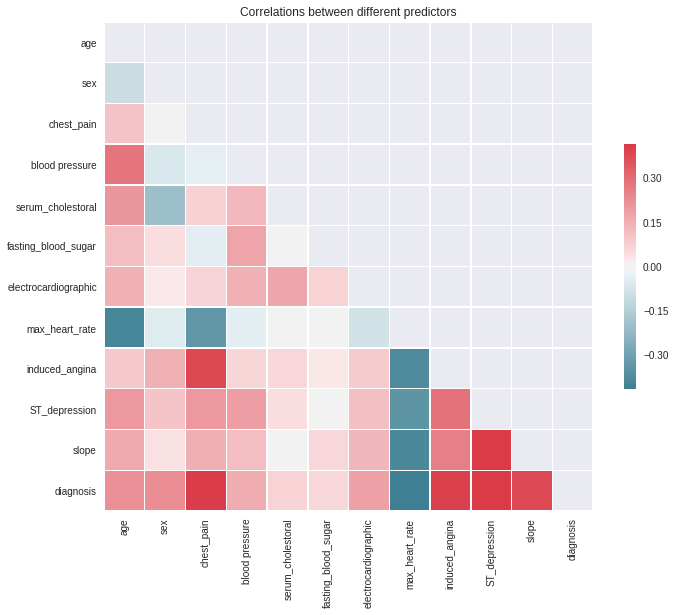

In [9]:
corr_df = df_full.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()

#**Data Cleaning and Transformation**

In [0]:
df_fullna = df_full.replace('?', np.nan)

In [11]:
df_fullna.isnull().sum()

age                     0
sex                     0
chest_pain              0
blood pressure          0
serum_cholestoral       0
fasting_blood_sugar     0
electrocardiographic    0
max_heart_rate          0
induced_angina          0
ST_depression           0
slope                   0
vessels                 4
thal                    2
diagnosis               0
dtype: int64

In [0]:
df = df_fullna
df = df.convert_objects(convert_numeric=True) #turn data into numeric type for computation

In [0]:
df['vessels'] = df['vessels'].fillna(df['vessels'].median())
df['thal'] = df['thal'].fillna(df['thal'].median())

In [14]:
df.isnull().sum() 

age                     0
sex                     0
chest_pain              0
blood pressure          0
serum_cholestoral       0
fasting_blood_sugar     0
electrocardiographic    0
max_heart_rate          0
induced_angina          0
ST_depression           0
slope                   0
vessels                 0
thal                    0
diagnosis               0
dtype: int64

In [0]:
df.loc[:, "diagnosis"] = df.loc[:, "diagnosis"].apply(lambda x: 1 if x >= 1 else 0)

In [0]:
df2=df

#**Spliting Data for Training and Testing**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2['diagnosis'], 
                                                    test_size = 0.33, random_state=44,
                                                   stratify= df2['diagnosis'] )

In [18]:
print(X_train.shape)
print(X_test.shape)

(203, 13)
(100, 13)


In [19]:
print(y_train[0:5])

267    1
179    0
67     0
92     0
96     1
Name: diagnosis, dtype: int64


# **Model 1: RF**

In [0]:
df.head()

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,thal,diagnosis
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


**Grid Search**

Detailed classification report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.83        54
           1       0.88      0.65      0.75        46

   micro avg       0.80      0.80      0.80       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.81      0.80      0.80       100

Confusion Matrix:
[[50  4]
 [16 30]]


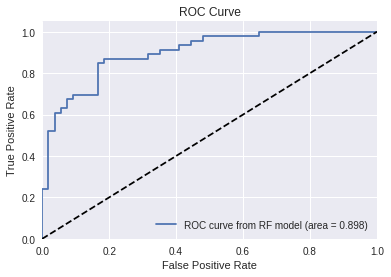

Best parameters:
{'class_weight': None, 'max_depth': 3, 'n_estimators': 10, 'random_state': 42}


In [0]:
# Grid Search CV searches over all the possible combination of hyperparameters and fits the model with the best set of hyperparameters
tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],'max_depth':[2,3,4,5,6,None],
                     'class_weight':[None,{0: 0.33,1:0.67},'balanced'],'random_state':[42]}]
clf_rf = GridSearchCV(RandomForestClassifier(criterion = 'entropy'), tuned_parameters, cv=10,scoring='accuracy')
clf_rf.fit(X_train, y_train)

print("Detailed classification report:")
y_true, lr_pred = y_test, clf_rf.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf_rf, X_test, y_test, 'RF')

print('Best parameters:')
print(clf_rf.best_params_)
clf_rf_best = clf_rf.best_estimator_

**Accuracy Score**

In [0]:
acc=sklearn.metrics.accuracy_score(y_test, clf_rf.predict(X_test))
print("RF Accuracy ->"+str(acc*100))

RF Accuracy ->80.0


**Saving the model**

In [0]:
rf_file = open('rf.pckl', 'wb')
pickle.dump(clf_rf, rf_file)
rf_file.close()

# **Model 2: SVM**

**Grid Search**

Detailed classification report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        54
           1       0.84      0.80      0.82        46

   micro avg       0.84      0.84      0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

Confusion Matrix:
[[47  7]
 [ 9 37]]


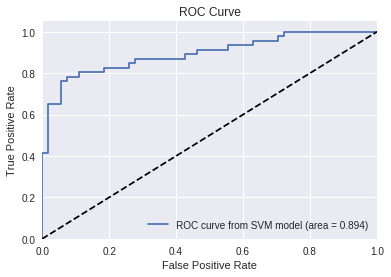

Best parameters:
{'C': 0.1, 'degree': 0, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 40}


In [0]:
tuned_parameters = [{'degree':[0, 1, 2, 3, 4],'C':[0.1, 1, 10],
                     'gamma':[0.1, 1, 10, 100],'kernel':['linear'],'random_state':[40]}]

clf_svm = GridSearchCV(SVC(), tuned_parameters, cv=10,scoring='accuracy')
clf_svm.fit(X_train, y_train)

print("Detailed classification report:")
y_true, lr_pred = y_test, clf_svm.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf_svm, X_test, y_test, 'SVM')

print('Best parameters:')
print(clf_svm.best_params_)
clf_svm_best = clf_svm.best_estimator_

**Accuracy Score**

In [0]:
acc=sklearn.metrics.accuracy_score(y_test, clf_svm.predict(X_test))
print("SVM Accuracy ->"+str(acc*100))
                                   
  

SVM Accuracy ->84.0


**Saving the model**

In [0]:
svm_file = open('svm.pckl', 'wb')
pickle.dump(clf_svm, svm_file)
svm_file.close()

# Neural Network Setup

In [0]:
from keras.models import Sequential
from keras.layers import Dense

In [0]:
X=df2.iloc[:,:-1]
y=df2['diagnosis']

In [22]:
print(X.shape)
print(y.shape)

(303, 13)
(303,)


#** 1 Layer Convolution Neural Network**

In [0]:
model1 = Sequential()
model1.add(Dense(1,input_dim=X.shape[1],activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

**Train model**

In [34]:
history1 = model1.fit(X,y,epochs=1000,batch_size=40,validation_split=.2,verbose=2)

Train on 242 samples, validate on 61 samples
Epoch 1/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 2/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 3/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 4/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 5/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 6/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 7/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 8/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 9/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 10/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 11/1000
 - 0s - loss: 8.8935 - acc: 0.4421 - val_loss: 7.5792 - val_acc: 0.5246
Epoch 12/1000
 - 0

**Plots**

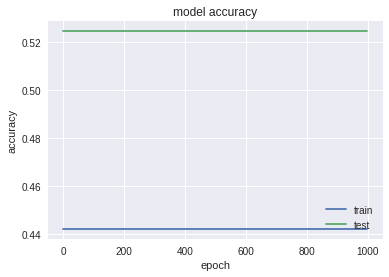

In [35]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

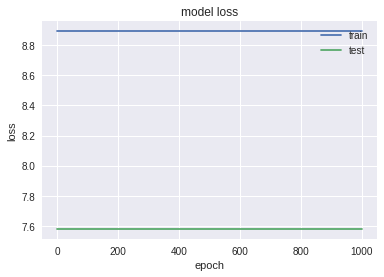

In [36]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Accuracy Score**

In [37]:
scores = model1.evaluate(X,y)
print("\n%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))

303/303 [==============================] - 0s 33us/step

acc: 45.87%


# 2 Layers Convolution Neural Network

**Build and train model**

In [38]:
model2 = Sequential()
model2.add(Dense(10,input_dim=X.shape[1],init='uniform',activation='relu'))
model2.add(Dense(1,init='uniform',activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model2.fit(X,y,epochs=1000,batch_size=40,validation_split=.2,verbose=2)

Train on 242 samples, validate on 61 samples
Epoch 1/1000
 - 0s - loss: 0.6876 - acc: 0.5579 - val_loss: 0.6928 - val_acc: 0.4754
Epoch 2/1000
 - 0s - loss: 0.6778 - acc: 0.5950 - val_loss: 0.6874 - val_acc: 0.6230
Epoch 3/1000
 - 0s - loss: 0.6660 - acc: 0.6612 - val_loss: 0.6902 - val_acc: 0.5082
Epoch 4/1000
 - 0s - loss: 0.6561 - acc: 0.6074 - val_loss: 0.6982 - val_acc: 0.4918
Epoch 5/1000
 - 0s - loss: 0.6511 - acc: 0.6033 - val_loss: 0.6891 - val_acc: 0.5082
Epoch 6/1000
 - 0s - loss: 0.6482 - acc: 0.5744 - val_loss: 0.6945 - val_acc: 0.4918
Epoch 7/1000
 - 0s - loss: 0.6330 - acc: 0.6736 - val_loss: 0.6656 - val_acc: 0.5902
Epoch 8/1000
 - 0s - loss: 0.6384 - acc: 0.6860 - val_loss: 0.6601 - val_acc: 0.5902
Epoch 9/1000
 - 0s - loss: 0.6363 - acc: 0.7107 - val_loss: 0.6562 - val_acc: 0.6066
Epoch 10/1000
 - 0s - loss: 0.6266 - acc: 0.6694 - val_loss: 0.6714 - val_acc: 0.5902
Epoch 11/1000
 - 0s - loss: 0.6173 - acc: 0.6570 - val_loss: 0.6706 - val_acc: 0.5902
Epoch 12/1000
 - 0

**Plots**

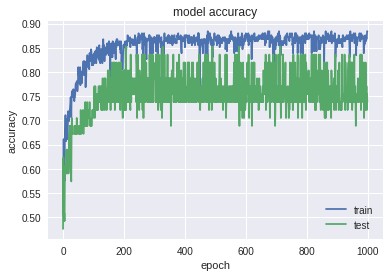

In [39]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

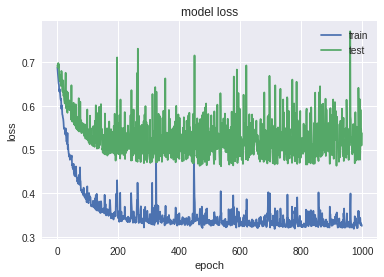

In [40]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Accuracy Score**

In [42]:
scores = model2.evaluate(X,y)
print("\n%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))

303/303 [==============================] - 0s 52us/step

acc: 85.15%


**Saving the model**

In [0]:
model2.save('model2.h5')

# 3 Layers Convolution Neural Network

**Build and train the model**

In [48]:
model3 = Sequential()
model3.add(Dense(12,input_dim=X.shape[1],init='uniform',activation='relu'))
model3.add(Dense(12,init='uniform',activation='relu'))
model3.add(Dense(1,init='uniform',activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3 = model3.fit(X,y,epochs=2000,validation_split=.2,verbose=2)

Train on 242 samples, validate on 61 samples
Epoch 1/2000
 - 0s - loss: 0.6908 - acc: 0.5579 - val_loss: 0.6952 - val_acc: 0.4754
Epoch 2/2000
 - 0s - loss: 0.6876 - acc: 0.5579 - val_loss: 0.6977 - val_acc: 0.4754
Epoch 3/2000
 - 0s - loss: 0.6855 - acc: 0.5579 - val_loss: 0.6989 - val_acc: 0.4754
Epoch 4/2000
 - 0s - loss: 0.6845 - acc: 0.5579 - val_loss: 0.7024 - val_acc: 0.4754
Epoch 5/2000
 - 0s - loss: 0.6811 - acc: 0.5579 - val_loss: 0.6995 - val_acc: 0.4754
Epoch 6/2000
 - 0s - loss: 0.6784 - acc: 0.5579 - val_loss: 0.7003 - val_acc: 0.4754
Epoch 7/2000
 - 0s - loss: 0.6749 - acc: 0.5579 - val_loss: 0.6951 - val_acc: 0.4754
Epoch 8/2000
 - 0s - loss: 0.6696 - acc: 0.5579 - val_loss: 0.6901 - val_acc: 0.4754
Epoch 9/2000
 - 0s - loss: 0.6631 - acc: 0.5620 - val_loss: 0.6868 - val_acc: 0.4918
Epoch 10/2000
 - 0s - loss: 0.6549 - acc: 0.6322 - val_loss: 0.6804 - val_acc: 0.5410
Epoch 11/2000
 - 0s - loss: 0.6425 - acc: 0.6570 - val_loss: 0.6829 - val_acc: 0.5246
Epoch 12/2000
 - 0

**Plots**

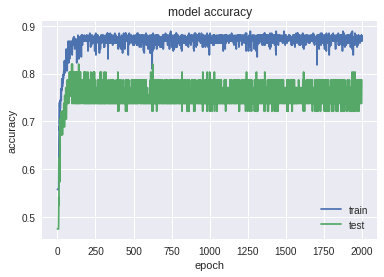

In [49]:
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

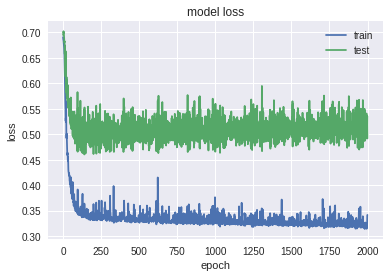

In [50]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Accuracy Score**

In [51]:
scores = model3.evaluate(X,y)
print("\n%s: %.2f%%" % (model3.metrics_names[1], scores[1]*100))

303/303 [==============================] - 0s 49us/step

acc: 85.48%


**Saving the model**

In [0]:
model3.save('model3.h5')

# 3 Layers Convolution Neural Network + Fine Tuning

**Build and train the model**

In [69]:
model4 = Sequential()
model4.add(Dense(64,input_dim=X.shape[1],init='uniform',activation='relu'))
model4.add(Dense(36,init='uniform',activation='relu'))
model4.add(Dense(1,init='uniform',activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history4 = model4.fit(X,y,epochs=5000,validation_split=.2,verbose=2)

Train on 242 samples, validate on 61 samples
Epoch 1/5000
 - 1s - loss: 0.6991 - acc: 0.4959 - val_loss: 0.7022 - val_acc: 0.4754
Epoch 2/5000
 - 0s - loss: 0.6777 - acc: 0.5579 - val_loss: 0.6958 - val_acc: 0.4918
Epoch 3/5000
 - 0s - loss: 0.6695 - acc: 0.5537 - val_loss: 0.6932 - val_acc: 0.5082
Epoch 4/5000
 - 0s - loss: 0.6574 - acc: 0.6281 - val_loss: 0.6744 - val_acc: 0.5738
Epoch 5/5000
 - 0s - loss: 0.6400 - acc: 0.6446 - val_loss: 0.7039 - val_acc: 0.5246
Epoch 6/5000
 - 0s - loss: 0.6253 - acc: 0.6529 - val_loss: 0.6598 - val_acc: 0.5410
Epoch 7/5000
 - 0s - loss: 0.5996 - acc: 0.6570 - val_loss: 0.6886 - val_acc: 0.5902
Epoch 8/5000
 - 0s - loss: 0.5907 - acc: 0.6860 - val_loss: 0.6584 - val_acc: 0.6066
Epoch 9/5000
 - 0s - loss: 0.5631 - acc: 0.7025 - val_loss: 0.6288 - val_acc: 0.6557
Epoch 10/5000
 - 0s - loss: 0.5482 - acc: 0.6983 - val_loss: 0.6226 - val_acc: 0.6885
Epoch 11/5000
 - 0s - loss: 0.5274 - acc: 0.7438 - val_loss: 0.7016 - val_acc: 0.5246
Epoch 12/5000
 - 0

**Plots**

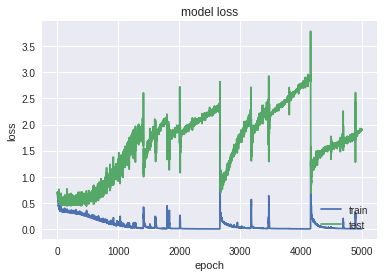

In [70]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

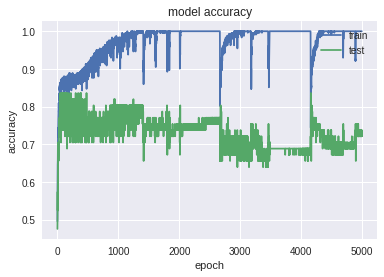

In [71]:
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Accuracy Score**

In [72]:
scores = model4.evaluate(X,y)
print("\n%s: %.2f%%" % (model4.metrics_names[1], scores[1]*100))

303/303 [==============================] - 0s 41us/step

acc: 94.39%


**Saving the model**

In [0]:
model4.save('model4.h5')

# **4 Layers Convolution Neural Network**

**Build and train the model**

In [58]:
model5 = Sequential()
model5.add(Dense(12,input_dim=X.shape[1],init='uniform',activation='relu'))
model5.add(Dense(10,init='uniform',activation='relu'))
model5.add(Dense(5,init='uniform',activation='relu'))
model5.add(Dense(1,init='uniform',activation='sigmoid'))

model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history5 = model5.fit(X_train,y_train,epochs=50,batch_size=40,validation_split=.2,verbose=2)

Train on 162 samples, validate on 41 samples
Epoch 1/50
 - 1s - loss: 0.6930 - acc: 0.5802 - val_loss: 0.6939 - val_acc: 0.3902
Epoch 2/50
 - 0s - loss: 0.6927 - acc: 0.5802 - val_loss: 0.6938 - val_acc: 0.3902
Epoch 3/50
 - 0s - loss: 0.6928 - acc: 0.5802 - val_loss: 0.6937 - val_acc: 0.3902
Epoch 4/50
 - 0s - loss: 0.6928 - acc: 0.5802 - val_loss: 0.6938 - val_acc: 0.3902
Epoch 5/50
 - 0s - loss: 0.6926 - acc: 0.5802 - val_loss: 0.6940 - val_acc: 0.3902
Epoch 6/50
 - 0s - loss: 0.6924 - acc: 0.5802 - val_loss: 0.6945 - val_acc: 0.3902
Epoch 7/50
 - 0s - loss: 0.6920 - acc: 0.5802 - val_loss: 0.6951 - val_acc: 0.3902
Epoch 8/50
 - 0s - loss: 0.6917 - acc: 0.5802 - val_loss: 0.6954 - val_acc: 0.3902
Epoch 9/50
 - 0s - loss: 0.6915 - acc: 0.5802 - val_loss: 0.6957 - val_acc: 0.3902
Epoch 10/50
 - 0s - loss: 0.6911 - acc: 0.5802 - val_loss: 0.6961 - val_acc: 0.3902
Epoch 11/50
 - 0s - loss: 0.6909 - acc: 0.5802 - val_loss: 0.6963 - val_acc: 0.3902
Epoch 12/50
 - 0s - loss: 0.6905 - acc: 

**Plots**

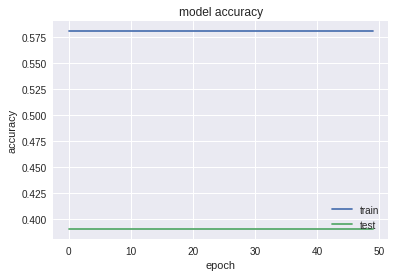

In [60]:
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

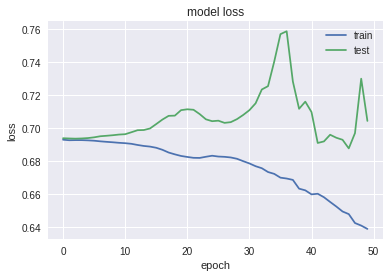

In [61]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Accuracy Score**

In [62]:
scores = model5.evaluate(X,y)
print("\n%s: %.2f%%" % (model5.metrics_names[1], scores[1]*100))

303/303 [==============================] - 0s 39us/step

acc: 54.13%


#**5 Layers Convolution Neural Neural Network**

In [129]:
model6 = Sequential()
model6.add(Dense(10,input_dim=X.shape[1],init='uniform',activation='relu'))
model6.add(Dense(10,init='uniform',activation='relu'))
model6.add(Dense(6,init='uniform',activation='relu'))
model6.add(Dense(3,init='uniform',activation='relu'))
model6.add(Dense(1,init='uniform',activation='sigmoid'))
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history6 = model6.fit(X_train,y_train,epochs=100,validation_split=.2,verbose=2)


Train on 162 samples, validate on 41 samples
Epoch 1/100
 - 2s - loss: 0.6931 - acc: 0.4815 - val_loss: 0.6935 - val_acc: 0.3902
Epoch 2/100
 - 0s - loss: 0.6928 - acc: 0.5802 - val_loss: 0.6938 - val_acc: 0.3902
Epoch 3/100
 - 0s - loss: 0.6927 - acc: 0.5802 - val_loss: 0.6939 - val_acc: 0.3902
Epoch 4/100
 - 0s - loss: 0.6926 - acc: 0.5802 - val_loss: 0.6939 - val_acc: 0.3902
Epoch 5/100
 - 0s - loss: 0.6925 - acc: 0.5802 - val_loss: 0.6942 - val_acc: 0.3902
Epoch 6/100
 - 0s - loss: 0.6924 - acc: 0.5802 - val_loss: 0.6944 - val_acc: 0.3902
Epoch 7/100
 - 0s - loss: 0.6922 - acc: 0.5802 - val_loss: 0.6947 - val_acc: 0.3902
Epoch 8/100
 - 0s - loss: 0.6920 - acc: 0.5802 - val_loss: 0.6950 - val_acc: 0.3902
Epoch 9/100
 - 0s - loss: 0.6918 - acc: 0.5802 - val_loss: 0.6953 - val_acc: 0.3902
Epoch 10/100
 - 0s - loss: 0.6917 - acc: 0.5802 - val_loss: 0.6956 - val_acc: 0.3902
Epoch 11/100
 - 0s - loss: 0.6914 - acc: 0.5802 - val_loss: 0.6959 - val_acc: 0.3902
Epoch 12/100
 - 0s - loss: 0.

**Plots**


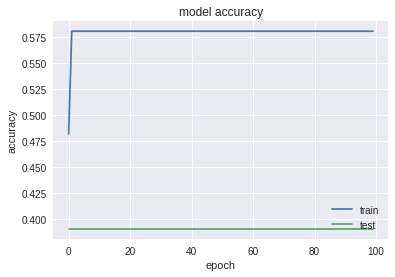

In [130]:
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

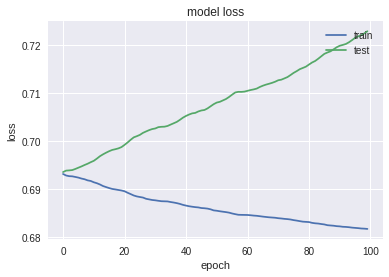

In [131]:
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [132]:
scores = model6.evaluate(X,y)
print("\n%s: %.2f%%" % (model6.metrics_names[1], scores[1]*100))

303/303 [==============================] - 0s 75us/step

acc: 54.13%


# --END--